In [5]:
### summary: TOP SCORES: 
#52.5% with gaussian naive bayes
#52.5% with k-nn with ~200 neighbors
#52.5% with logistic regression and C~1e-2
#52% with a 2 depth decision tree
#always going for 1 -> 51%

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
matplotlib.style.use('ggplot')
%matplotlib inline


In [6]:
numerai_data = pd.read_csv("./Datasets/numerai_training_data.csv")
print numerai_data.head(10)

#separating train and test
frac_for_training = 0.80
training_data = numerai_data.sample(frac=frac_for_training)
validation_data = numerai_data.drop(training_data.index)
check = pd.merge(training_data, validation_data, how='inner')

training_data.drop('validation', axis=1, inplace=True)
validation_data.drop('validation', axis=1, inplace=True)

print('\n\n\nSize of datasets: total - %s, train - %s, test - %s, intersect: %s' %(
        numerai_data.shape[0], training_data.shape[0], validation_data.shape[0], check.shape[0]))

          f1         f2         f3         f4         f5         f6  \
0  134182390   97300587  135824563   90767607   87687197   65148427   
1   76630357  132348601   78121737  102794263  120848626  128752983   
2  111610401  132186734   83887688  120772423  133722193  100560251   
3   72896251  113365043   72912608  126007508  127949612   74975809   
4  113253706   96665624   89391907   77862818   91855586  100094204   
5  122837395   71633727  125829672   73401946   66388998   71572170   
6  116917069   97255589  109352915   77622874   76834712   84847106   
7  108136714  110264481   99080283   95949194  108265520  100203479   
8  116917069  127552518  124961581  102269449  107669715   84416921   
9  107480622   91552319   78127446   84411308   98566229   84213901   

          f7         f8         f9        f10        f11        f12  \
0  109834029  131613166  135533479   92106582   98111205   87052852   
1   71827456   95945691   98115812  135285479  137364637  130062214   
2   6

In [7]:
#preprocessing the categorical feature c1

from sklearn import preprocessing

try:
    training_data["c1_int"] = training_data["c1"].apply(lambda x: int(x[3:]))
except Exception:
    le = preprocessing.LabelEncoder()
    le.fit_transform(list(set(training_data["c1"])))
    training_data["c1_int"] = le.transform(np.asarray(training_data["c1"]))

print "\n\n\nCategorical feature transformed:"
print training_data[["c1", "c1_int"]].head(10)

#features:
features = list(set(training_data.columns).difference({'target', 'validation','c1'}))
print ("\n\n\nFeatures are: %s" %','.join(features))






Categorical feature transformed:
          c1  c1_int
46001  c1_19      19
14000   c1_8       8
7577   c1_23      23
35846   c1_3       3
25061  c1_23      23
555     c1_3       3
40835  c1_18      18
685    c1_17      17
25473  c1_14      14
26673  c1_20      20



Features are: f1,f2,f3,f4,f5,f6,f7,f8,f9,c1_int,f12,f13,f10,f11,f14


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10b2cf410>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119198450>]], dtype=object)

/Users/hmaupard/Library/Python/2.7/lib/python/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


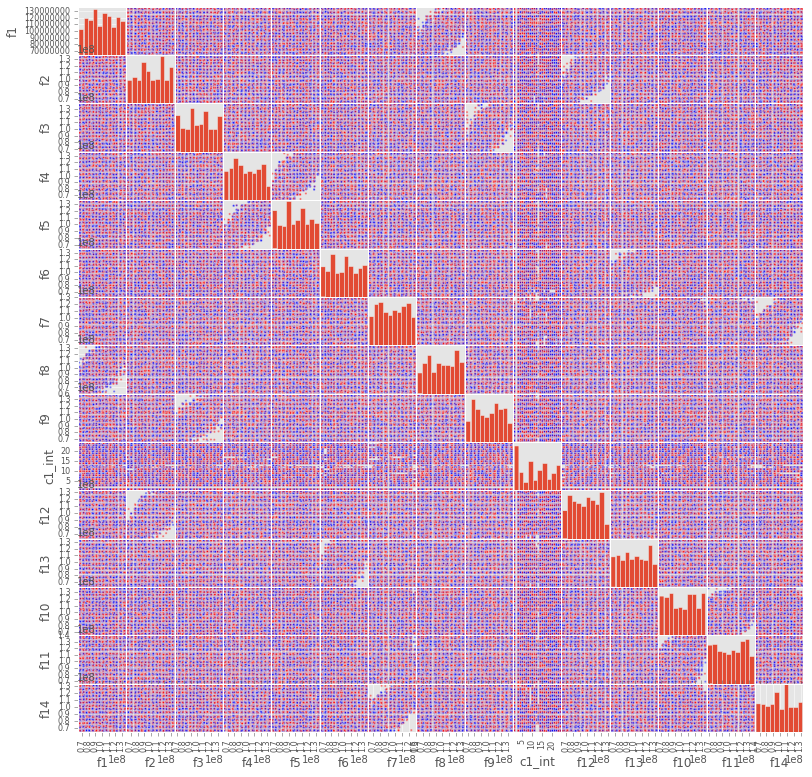

In [8]:
#plotting the entire dataset

from pandas.tools.plotting import scatter_matrix

cols = {0:'blue', 1:'red'}
features = list(set(training_data.columns).difference({'target', 'validation','c1'}))

scatter_matrix(training_data.ix[:,features], 
               figsize=(13, 13), diagonal='hist', c=training_data["target"].apply(lambda x:cols[x]))

In [4]:
#dirty PCA on the entire training sample (not great for cross val but osef)
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
features = [f for f in set(training_data.columns) if f.startswith("f")]

#gaussian scaling
training_data_scaled = training_data.copy(deep=True)
training_data_scaled[features] = scale(training_data[features], axis=0, with_mean=True, with_std=True, copy=True)

print "Before PCA, after scaling"
print training_data_scaled.head(20)

pca_ = PCA()
pca_.fit(training_data_scaled[features])
training_data_pcaed = training_data_scaled.copy(deep=True)
training_data_pcaed[features] = pca_.transform(training_data_scaled[features])

print "After PCA, after scaling"
print training_data_pcaed.head(20)

variance_cutoff = 0.75
features = features[0:(1+np.argmax(np.cumsum(np.array(pca_.explained_variance_ratio_))>variance_cutoff))]#REDUCE FEATURES
print features

#print pca_.components_
#print np.sum(pca_.explained_variance_ratio_)
#print pca_.explained_variance_ratio_
#print pca_.components_[0]
#print pca_.noise_variance_
#print np.sum(np.array(pca_.components_[0])**2)
#print pca_.mean_
#print training_data_pcaed.dtypes
#print training_data_pcaed.head(20)

training_data = training_data_pcaed.copy(deep=True)

Before PCA, after scaling
             f1        f2        f3        f4        f5        f6        f7  \
2758  -0.982078  1.663668  0.096415  1.497840  1.480606  0.337143 -1.448382   
47930 -1.254872  0.672743 -1.222626 -1.632181 -1.442339  1.154989  1.090272   
22610  1.114261  0.621596  1.503540 -0.036181 -0.367080  0.875917 -1.110716   
13173  0.906787 -0.999798 -0.883630 -1.042964 -1.243613 -0.717194  1.407866   
38835  0.591658  0.400091 -1.725336  1.236042  1.494974  1.147727 -0.393679   
40584 -0.428448  0.647681 -1.496347  0.922456  1.216651  0.378396 -1.086996   
6998   1.114261 -0.434575 -1.204232 -0.919320 -1.483759  1.156542  0.858428   
27117 -0.770254 -0.764688  1.184920 -0.071370 -0.124220 -0.234413 -0.814636   
24936 -1.752548 -0.196153 -1.439914  1.848363  1.782319 -0.918995 -0.105212   
16366  0.401130  0.892181 -0.073620  0.577931  0.638362  0.923163 -1.367942   
28172  1.141426 -1.576090  1.211405 -1.627321 -1.177975 -0.717194  0.768159   
15110  1.394063 -0.727464 

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [5]:
#naive bayes

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score

#features = ["f3","f11"]
features = [f for f in set(training_data.columns) if f.startswith("f")]

alphas = [1.0]
def cv_score(al):
    clf = MultinomialNB(al)
    clf.fit(training_data[features], training_data["target"])
    s = clf.score(training_data[features], training_data["target"])
    m = np.mean(cross_val_score(clf, training_data[features], training_data["target"], cv=10))
    dat = np.array([al, s, m])
    return pd.DataFrame([dat],columns=['alpha','training_score', 'validation_score'])

single_classif_tree_scores = pd.concat(map(cv_score, alphas))
single_classif_tree_scores.index = single_classif_tree_scores['alpha']
single_classif_tree_scores.drop('alpha',axis=1, inplace=True)

print single_classif_tree_scores
#single_classif_tree_scores.plot(legend=True, grid=True)

ValueError: Input X must be non-negative

In [5]:
#naive bayes for categories
from numpy import prod
import math

class NBCategoricalClassifier:
        
    def __init__(self):
        return

        
    def fit(self, my_features, my_target, my_training_data):
        self.features = my_features
        self.training_data = my_training_data
        self.target = my_target
        self.target_classes = list(set(list(self.training_data[self.target])))
        self.n = len(self.features)
        self.K = len(set(list(self.training_data[self.target])))
        self.P_y = dict()
        self.P_x_given_y = dict()
        
        self.P_y = self.training_data.groupby(self.target).count()
        temp_name = self.P_y.columns[0]
        self.P_y = self.P_y.apply(lambda x: x/x.sum(), axis=0)[[temp_name]].to_dict()[temp_name]
        for y in self.P_y.keys():
            self.P_x_given_y[y] = dict(zip(self.features, [dict()]*self.n))
        
        for y in self.target_classes:
            for feature in self.features:
                conditional_dist = self.training_data[self.training_data[self.target]==y]
                conditional_dist = conditional_dist[[feature, self.target]]
                conditional_dist = conditional_dist.groupby(feature).count()
                conditional_dist = conditional_dist.apply(lambda x: x/x.sum(), axis=0)
                self.P_x_given_y[y][feature] = conditional_dist.to_dict()[self.target]
    
    def predict(self, test_data):
        def probs(row):
            best_target = self.target_classes[0]
            best_proba = 0.0
            for y in self.target_classes:
                p = self.P_y[y]
                for x in features:
                    try:
                        p = p * self.P_x_given_y[y][x][row.ix[x,0]]
                    except Exception:
                        p = 0.0
                if (p>best_proba):
                    best_proba = p
                    best_target = y
            return best_target
        test_data["y_hat"] = test_data.apply(probs, axis=1)
        return list(test_data["y_hat"])
    
    def score(self, my_test_data, my_target):
        predictions = self.predict(my_test_data)
        return float(len([1 for (pred, actual) in zip(
                       predictions, list(my_test_data[my_target])) if pred==actual]))/float(my_test_data.shape[0])
    
    @staticmethod
    def cross_validate(my_data, my_features, my_target, n_folds):
        def score_on_fold(i, n):
            my_out_of_sample_slice = range(int(math.floor(my_data.shape[0]*float(i)/n)), int(math.ceil(my_data.shape[0]*float(i+1)/n)))
            my_in_sample_slice = sorted(list(set(range(0, my_data.shape[0])).difference(set(my_out_of_sample_slice))))
            my_training_data = my_data.iloc[my_in_sample_slice,:]
            my_testing_data = my_data.iloc[my_out_of_sample_slice,:]
            nb = NBCategoricalClassifier()
            nb.fit(my_features, my_target, my_training_data)
            return nb.score(my_testing_data, my_target)
        return map(lambda i: score_on_fold(i,n_folds), range(0,n_folds))
    
    
    

In [6]:
nb = NBCategoricalClassifier()
features = features[0:(1+np.argmax(np.cumsum(np.array(pca_.explained_variance_ratio_))>variance_cutoff))]#REDUCE FEATURES
nb.fit(features, 'target', training_data[features+['target']])

IS = nb.score(training_data[features+['target']], 'target')
print IS
OS = np.mean(NBCategoricalClassifier.cross_validate(training_data[features+['target']], features, 'target', 20))
print OS

1.0
0.492665758401


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
print features

Index([u'f1', u'f2', u'f3', u'f4', u'f5'], dtype='object')


In [15]:
#naive bayes gaussian

from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score

nb_gaussian_training_data = training_data.copy()
features = features[0:(1+np.argmax(np.cumsum(np.array(pca_.explained_variance_ratio_))>variance_cutoff))]#REDUCE FEATURES
#features = [f for f in set(nb_gaussian_training_data.columns) if f.startswith("f")]
minmax_scale = preprocessing.MinMaxScaler().fit(nb_gaussian_training_data[features])
nb_gaussian_training_data[features] = minmax_scale.transform(nb_gaussian_training_data[features])

#print nb_gaussian_training_data[features].head(20)

clf = GaussianNB()
clf.fit(nb_gaussian_training_data[features], nb_gaussian_training_data["target"])
s = clf.score(nb_gaussian_training_data[features], nb_gaussian_training_data["target"])
m = np.mean(cross_val_score(clf, nb_gaussian_training_data[features], nb_gaussian_training_data["target"], cv=10))
print "in sample score: %s, out of sample score: %s" %(s,m)



in sample score: 0.509107426754, out of sample score: 0.508971202491


In [ ]:
cross_val_scores_per_category = dict()

for cat in categories

['f1', 'f2', 'f3', 'f4', 'f5']


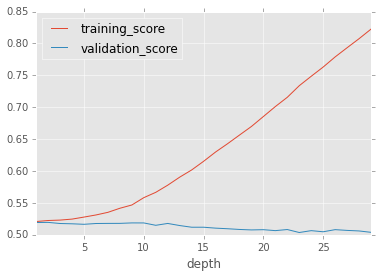

In [8]:
#classification score with a single regression tree

from sklearn import tree
from sklearn.cross_validation import cross_val_score

features = features[0:(1+np.argmax(np.cumsum(np.array(pca_.explained_variance_ratio_))>variance_cutoff))]#REDUCE FEATURES
print features

max_depths = range(1,30)
def cv_score(depth, printTree=False):
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf.fit(training_data[features], training_data["target"])
    s = clf.score(training_data[features], training_data["target"])
    m = np.mean(cross_val_score(clf, training_data[features], training_data["target"], cv=5))
    dat = np.array([depth, s, m])
    if printTree:
        with open('./ClassificationTrees/singleClassifTreeWithDepth'+str(depth)+'.dot', 'w') as my_file:
            my_file = tree.export_graphviz(clf, out_file = my_file)
    return pd.DataFrame([dat],columns=['depth','training_score', 'validation_score'])

single_classif_tree_scores = pd.concat(map(lambda d: cv_score(d, True), max_depths))
single_classif_tree_scores.index = single_classif_tree_scores['depth']
single_classif_tree_scores.drop('depth',axis=1, inplace=True)

single_classif_tree_scores.plot(legend=True, grid=True)


In [9]:
print single_classif_tree_scores

       training_score  validation_score
depth                                  
1            0.521326          0.518578
2            0.523461          0.520395
3            0.523620          0.520372
4            0.525278          0.519714
5            0.530434          0.519396
6            0.535067          0.516148
7            0.539677          0.521485
8            0.548285          0.519237
9            0.558801          0.518351
10           0.568272          0.516920
11           0.579378          0.514331
12           0.595231          0.512900
13           0.614581          0.516012
14           0.630207          0.511606
15           0.651760          0.511220
16           0.674540          0.511651
17           0.694413          0.512310
18           0.713491          0.512083
19           0.735362          0.510289
20           0.753986          0.510493
21           0.775380          0.509403
22           0.793732          0.509357
23           0.811083          0.508062


['f1', 'f2', 'f3', 'f4', 'f5']
              training_score  validation_score
n_estimators                                  
1                   0.521622          0.520736
4                   0.534567          0.520463
7                   0.569362          0.518556
10                  0.650079          0.516375
13                  0.752646          0.514286
16                  0.851465          0.512355
19                  0.927254          0.510061
22                  0.961731          0.507609
25                  0.988576          0.506813
28                  0.996434          0.505428
31                  0.999023          0.503770
34                  0.999841          0.504452
37                  0.999773          0.504111
40                  0.999932          0.506041
43                  0.999955          0.504701
46                  0.999932          0.506382
49                  1.000000          0.504134


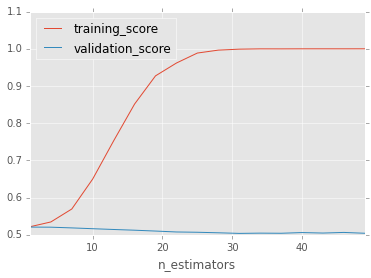

In [9]:
# random forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

features = features[0:(1+np.argmax(np.cumsum(np.array(pca_.explained_variance_ratio_))>variance_cutoff))]#REDUCE FEATURES
print features

max_depth_from_tree_cv = 7
params = range(1,50,3)
def cv_score(par):
    clf = RandomForestClassifier(n_estimators=50, max_depth = par)
    clf.fit(training_data[features], training_data["target"])
    s = clf.score(training_data[features], training_data["target"])
    m = np.mean(cross_val_score(clf, training_data[features], training_data["target"], cv=5))
    dat = np.array([par, s, m])
    return pd.DataFrame([dat],columns=['n_estimators','training_score', 'validation_score'])

random_forest_tree_scores = pd.concat(map(cv_score, params))
random_forest_tree_scores.index = random_forest_tree_scores['n_estimators']
random_forest_tree_scores.drop('n_estimators',axis=1, inplace=True)

print random_forest_tree_scores
random_forest_tree_scores.plot(legend=True, grid=True)




['f1', 'f2', 'f3', 'f4', 'f5']
             training_score  validation_score
n_neighbors                                  
10                 0.628412          0.501590
60                 0.554054          0.508381
110                0.545174          0.511356
160                0.538292          0.512946
210                0.536680          0.514218
260                0.535953          0.516489
310                0.535385          0.518851
360                0.533046          0.518624
410                0.528935          0.519782
460                0.529980          0.520849


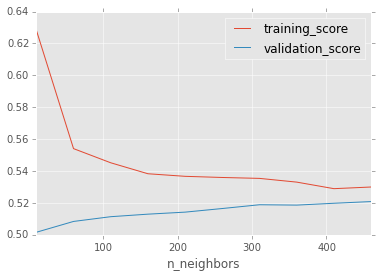

In [13]:
#k-nn

from sklearn import preprocessing

#features = [f for f in set(training_data.columns) if f.startswith("f")]
#minmax_scale = preprocessing.MinMaxScaler().fit(training_data[features])
#training_data[features] = minmax_scale.transform(training_data[features])

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

n_neighbors = range(10,500,50)
features = features[0:(1+np.argmax(np.cumsum(np.array(pca_.explained_variance_ratio_))>variance_cutoff))]#REDUCE FEATURES
print features

def cv_score(par):
    clf = KNeighborsClassifier(n_neighbors=par)
    clf.fit(training_data[features], training_data["target"])
    s = clf.score(training_data[features], training_data["target"])
    m = np.mean(cross_val_score(clf, training_data[features], training_data["target"], cv=5))
    dat = np.array([par, s, m])
    return pd.DataFrame([dat],columns=['n_neighbors','training_score', 'validation_score'])

k_nn_scores = pd.concat(map(cv_score, n_neighbors))
k_nn_scores.index = k_nn_scores['n_neighbors']
k_nn_scores.drop('n_neighbors',axis=1, inplace=True)

print k_nn_scores
k_nn_scores.plot(legend=True, grid=True)




['f1', 'f2', 'f3', 'f4', 'f5']


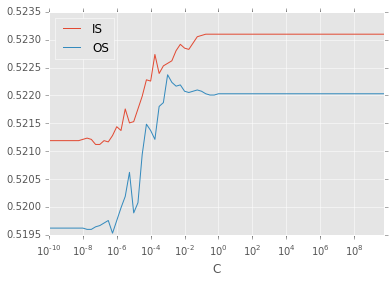

In [11]:
#Logistic regression

from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
import math

params = np.exp(np.arange(-10.0, 10.0,.25)*math.log(10))
features = features[0:(1+np.argmax(np.cumsum(np.array(pca_.explained_variance_ratio_))>variance_cutoff))]#REDUCE FEATURES
print features

logistic_reg_training_data = training_data.copy()
#features = [f for f in set(logistic_reg_training_data.columns) if f.startswith("f")]
#minmax_scale = preprocessing.MinMaxScaler().fit(logistic_reg_training_data[features])
#logistic_reg_training_data[features] = minmax_scale.transform(logistic_reg_training_data[features])

def apply_param(p):
    lreg_model = sklearn.linear_model.LogisticRegression(C=p)
    lreg_model.fit(logistic_reg_training_data[features], logistic_reg_training_data["target"])
    IS = lreg_model.score(logistic_reg_training_data[features], logistic_reg_training_data["target"])
    OS = np.mean(cross_val_score(lreg_model, logistic_reg_training_data[features], logistic_reg_training_data["target"], cv=10))
    return pd.DataFrame([np.array([p, IS, OS])], columns=['C', 'IS', 'OS']) 

scores = pd.concat(map(apply_param, params))
scores.plot(x='C',logx=True)





array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11133cfd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x111e23b10>]], dtype=object)

/Users/hmaupard/Library/Python/2.7/lib/python/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


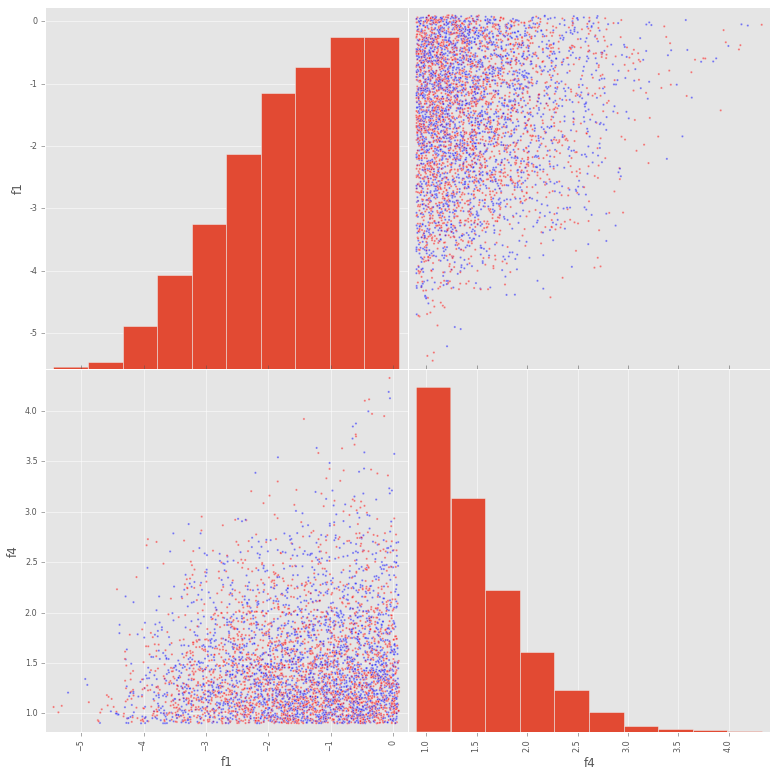

In [14]:
# plotting subreagions of the dataset

from pandas.tools.plotting import scatter_matrix
cols = {0:'blue', 1:'red'}
feature1 = "f1"
feature2="f4"
#features = list(set(training_data.columns).difference({'target', 'validation','c1'}))
features = [feature1,feature2]
scatter_matrix(training_data.ix[training_data.apply(lambda u:u[feature1]<0.10 and u[feature2]>0.90, axis=1),features], 
               figsize=(13, 13), diagonal='hist', c=training_data["target"].apply(lambda x:cols[x]))

In [36]:
features = sample(training_data.columns, trai)
naive_bayes = training_data.groupby("target").mean()
naive_bayes_std = training_data.groupby("target").std()

In [20]:
correl_matrix = training_data.corr()
print correl_matrix

              f1        f2        f3        f4        f5        f6        f7  \
f1      1.000000 -0.163394  0.428733 -0.325377 -0.371042 -0.088483  0.163529   
f2     -0.163394  1.000000 -0.063000  0.202086  0.267451  0.359337 -0.294290   
f3      0.428733 -0.063000  1.000000 -0.181874 -0.204765 -0.131397  0.066154   
f4     -0.325377  0.202086 -0.181874  1.000000  0.873783  0.000847 -0.299648   
f5     -0.371042  0.267451 -0.204765  0.873783  1.000000  0.020243 -0.308011   
f6     -0.088483  0.359337 -0.131397  0.000847  0.020243  1.000000 -0.084130   
f7      0.163529 -0.294290  0.066154 -0.299648 -0.308011 -0.084130  1.000000   
f8      0.881081 -0.123326  0.389032 -0.349595 -0.330851 -0.059940  0.136005   
f9      0.389950 -0.040586  0.899013 -0.206489 -0.188177 -0.110266  0.044167   
f10    -0.167903  0.565475 -0.072287  0.296480  0.357606  0.178166 -0.484876   
f11    -0.153923  0.499247 -0.063860  0.286539  0.296125  0.157247 -0.583900   
f12    -0.143130  0.857181 -0.048527  0.

In [63]:
u = training_data.groupby("target").agg({"f1":len})
u = u["f1"]
u = u/np.sum(u)
print u

target
0    0.492891
1    0.507109
Name: f1, dtype: float64


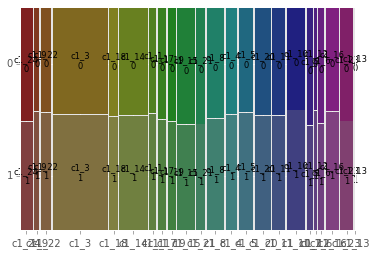

In [37]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 10.0
m = mosaic(training_data, ['c1', 'target'])

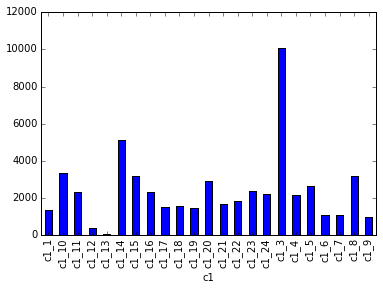

In [43]:
training_data.groupby('c1').size().plot(kind='bar')

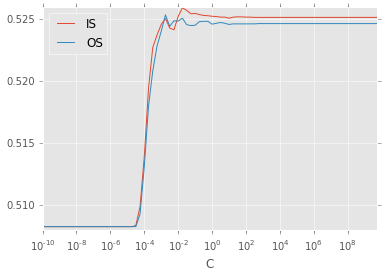

In [26]:
#Logistic regression

from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
import math

params = np.exp(np.arange(-10.0, 10.0,.25)*math.log(10))

#logistic_reg_training_data = training_data.copy()
#features = [f for f in set(logistic_reg_training_data.columns) if f.startswith("f")]
#minmax_scale = preprocessing.MinMaxScaler().fit(logistic_reg_training_data[features])
#logistic_reg_training_data[features] = minmax_scale.transform(logistic_reg_training_data[features])

def apply_param(p):
    lreg_model = sklearn.linear_model.LogisticRegression(C=p)
    lreg_model.fit(logistic_reg_training_data[features], logistic_reg_training_data["target"])
    IS = lreg_model.score(logistic_reg_training_data[features], logistic_reg_training_data["target"])
    OS = np.mean(cross_val_score(lreg_model, logistic_reg_training_data[features], logistic_reg_training_data["target"], cv=10))
    return pd.DataFrame([np.array([p, IS, OS])], columns=['C', 'IS', 'OS']) 

scores = pd.concat(map(apply_param, params))
scores.plot(x='C',logx=True)





In [19]:
p = 0.005
lreg_model = sklearn.linear_model.LogisticRegression(C=p)
lreg_model.fit(logistic_reg_training_data[features], logistic_reg_training_data["target"])
print lreg_model.coef_
print lreg_model.intercept_
print lreg_model.n_iter_

[[ 0.57464308  0.54806492  0.5474383   0.557103    0.56904745  0.54075754
   0.63155001  0.59121368  0.5461635   0.50337197  0.54534179  0.53529438
   0.54489352  0.64560449]]
[ 0.95971454]
[7]


In [24]:
pred = lreg_model.predict(logistic_reg_training_data[features])
act = list(logistic_reg_training_data['target'])
print zip(pred, act)

[(1, 1), (-1, -1), (-1, -1), (1, 1), (-1, -1), (1, 1), (-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1), (1, 1), (1, 1), (-1, -1), (-1, -1), (1, 1), (1, 1), (1, 1), (-1, -1), (-1, -1), (1, 1), (1, 1), (-1, -1), (-1, -1), (-1, -1), (-1, -1), (1, 1), (-1, -1), (1, 1), (1, 1), (-1, -1), (1, 1), (1, 1), (-1, -1), (-1, -1), (1, 1), (1, 1), (-1, -1), (-1, -1), (-1, -1), (1, 1), (1, 1), (1, 1), (1, 1), (-1, -1), (-1, -1), (-1, -1), (1, 1), (1, 1), (1, 1), (-1, -1), (-1, -1), (-1, -1), (1, 1), (1, 1), (-1, -1), (1, 1), (1, 1), (1, 1), (1, 1), (-1, -1), (-1, -1), (1, 1), (1, 1), (-1, -1), (-1, -1), (1, 1), (-1, -1), (-1, -1), (-1, -1), (1, 1), (1, 1), (1, 1), (1, 1), (-1, -1), (1, 1), (1, 1), (-1, -1), (1, 1), (1, 1), (1, 1), (-1, -1), (-1, -1), (1, 1), (-1, -1), (-1, -1), (1, 1), (1, 1), (1, 1), (1, 1), (-1, -1), (-1, -1), (1, 1), (-1, -1), (-1, -1), (-1, -1), (-1, -1), (1, 1), (-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1), (1, 1), (-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1), (1, 1), (

In [23]:
score = len([v for (v,t) in zip(u, list(logistic_reg_training_data['target'])) if v==t])/float(logistic_reg_training_data.shape[0])
print score

1.0


In [22]:
len(u)

44030